In [1]:
import os
import glob
import joblib
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from scipy.stats import zscore
from os.path import join as pjoin
from sklearn.decomposition import PCA
from utils import get_roi_data, save_ciftifile, conv2_labels, save2cifti

# dataset
work_dirs = {'nod': '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/',
            'nsd': '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/NSD-mfm' }
# dataset name
dataset = 'nod'
# working dir
wk_dir = work_dirs[dataset]
corr_path = os.path.join(wk_dir, 'build/featurewise-corr/last-12-feature')
voxel_mask_path = os.path.join(wk_dir, 'prep/voxel_masks/')

subs = [f'sub-0{i+1}' for i in list(range(9))]
bmaskname = 'subjvis'
layername = 'googlenet-conv2'
modelname = 'RFmodels'

mask_name = 'primaryvis-in-MMP'
voxel_mask_nii = nib.load(os.path.join(voxel_mask_path, f'{dataset}-voxmask_{mask_name}.dlabel.nii'))
voxel_mask = np.squeeze(voxel_mask_nii.get_fdata())
voxel_indices = np.where(voxel_mask==1)[0]

# generate specific ROI
v1_voxels = np.array([ _ for _ in np.where(get_roi_data(None, 'V1')==1)[0] if _ in voxel_indices])
v2_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V2')==1)[0] if _ in voxel_indices])
v3_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V3')==1)[0] if _ in voxel_indices])
v4_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V4')==1)[0] if _ in voxel_indices])

# sharing_repeats = nib.load(os.path.join(voxel_mask_path, 'nod-voxmask_gmmret-in-subj-repeats.dscalar.nii')).get_fdata()
# mask_gmm = nib.load(os.path.join(voxel_mask_path, 'nod-voxmask_gmmret-in-subj.dlabel.nii')).get_fdata()
# mask_fix = nib.load(os.path.join(voxel_mask_path, 'nod-voxmask_fixret-in-subj.dlabel.nii')).get_fdata()

In [18]:
# 载入每个被试、每个feature的beta值
indexname = 'fullm-coef'
betas = []
pattern =os.path.join(corr_path, f"sub-*/*{indexname}.npy")
files = glob.glob(pattern)
files = sorted(files)
for file in files:
    beta = np.load(file)
    betas.append(beta)
    # print(file.split('/')[-1], ':', beta.shape)
    # print(file.split('/')[-1], ':', np.nanmin(beta), np.nanmax(beta))
    uniq_vox = np.unique(np.where(np.isnan(beta[:, voxel_indices])==1)[1])
    num_vox = len(np.where(np.isnan(beta[:, voxel_indices])==1)[1])
    average_nan = num_vox/(len(uniq_vox)+1e-18)
    # print('# nan voxel:',num_vox, '; include', uniq_vox, '; average nan per voxel', average_nan)
betas = np.stack(betas, axis=0)
print(f'tell me the shape of {indexname}:', betas.shape)
# 载入全模型显著性
statsmethod = 'FDR'
sigpath = pjoin(wk_dir, 'anal/brainmap/modelsigmap')
fullmodel_sig = nib.load(pjoin(sigpath, f'sub-all_ly-googlenet-conv2_modelSig-{statsmethod}.dlabel.nii')).get_fdata()

tell me the shape of fullm-coef: (9, 11, 59412)


### 各特征beta系数在ROI（V1）上的显著性
- 考察不同的体素筛选办法

In [3]:
# 提取出 full model 的 p 值
indexname = 'fullm-f-pvalue'
fpvalues = []
pattern =os.path.join(corr_path, f"sub-*/*{indexname}.npy")
files = glob.glob(pattern)
files = sorted(files)
for file in files:
    fpvalue = np.load(file)
    fpvalues.append(fpvalue)
    # print(file.split('/')[-1], ':', pvalue.shape)
    # print(file.split('/')[-1], ':', np.nanmin(pvalue), np.nanmax(pvalue))
    uniq_vox = np.unique(np.where(np.isnan(fpvalue[:, voxel_indices])==1)[1])
    num_vox = len(np.where(np.isnan(fpvalue[:, voxel_indices])==1)[1])
    average_nan = num_vox / (len(uniq_vox) + 1e-18)
    # print('# nan voxel:',num_vox, '; include', uniq_vox, '; average nan per voxel', average_nan)
    # print('# significant ratio:',np.sum(pvalue[:, voxel_indices]<0.05)/ pvalue[:, voxel_indices].size)
fpvalues = np.stack(fpvalues, axis=0)[:,0,:]
print(fpvalues.shape)

# 对每个被试、各个体素的全模型的显著性进行排序
sigrank_roi = {}
show_roi = v1_voxels
for isub, sub in enumerate(subs):
    sort_fpv = np.argsort(fpvalues[isub, show_roi])
    sigrank_roi[sub] = show_roi[sort_fpv]

(9, 59412)


In [4]:
# 提取出 feature p 值
indexname = 'fullm-p'
pvalues = []
pattern =os.path.join(corr_path, f"sub-*/*{indexname}.npy")
files = glob.glob(pattern)
files = sorted(files)
for file in files:
    pvalue = np.load(file)
    pvalues.append(pvalue)
    # print(file.split('/')[-1], ':', pvalue.shape)
    # print(file.split('/')[-1], ':', np.nanmin(pvalue), np.nanmax(pvalue))
    uniq_vox = np.unique(np.where(np.isnan(pvalue[:, voxel_indices])==1)[1])
    num_vox = len(np.where(np.isnan(pvalue[:, voxel_indices])==1)[1])
    average_nan = num_vox / (len(uniq_vox) + 1e-18)
    # print('# nan voxel:',num_vox, '; include', uniq_vox, '; average nan per voxel', average_nan)
    # print('# significant ratio:',np.sum(pvalue[:, voxel_indices]<0.05)/ pvalue[:, voxel_indices].size)
pvalues = np.stack(pvalues, axis=0)
print(pvalues.shape)

(9, 11, 59412)


In [3]:
import numpy as np
singlesig_filter = np.array([1,47,60,49,28,29,37,21,42,45,3,35,17,57,58,25])


singlesig_filter[np.array([0,6,4,1,3,8,9,11,10,13,14])]


array([ 1, 37, 28, 47, 49, 42, 45, 35,  3, 57, 58])

In [6]:
singlesig_filter =  np.array([ 1, 37, 28, 47, 49, 42, 45, 35,  3, 57, 58]) #np.array([1,47,60,49,28,29,37,21,42,45,3,35,17,57,58,25])
filtered_conv2_labels = {}

for key, features in conv2_labels.items():
    intersection = list(set(features) & set(singlesig_filter))
    if len(intersection)>0:

        filtered_conv2_labels[key] = [list(singlesig_filter).index(_) for _ in intersection]
filtered_conv2_labels

{'lowfreq': [0, 1, 3, 4, 2],
 'colorcontrast': [5, 6],
 'multicolor': [7, 8, 9],
 'complxgabor': [10]}

In [25]:
# feature beta scatter，对每一类特征，挑出显著的体素， 查看显著β值的具体状况
subcolors = ['#404e67',  '#809bce',  '#95b8d1',  '#b8e0d4',  '#d6eadf',  '#eac4d5',  '#d1625c',  '#e89c81', '#ffd6a5']
label_dict = filtered_conv2_labels #conv2_labels
setcolors = plt.cm.jet(np.linspace(0, 1, len(label_dict.keys())))
center_biases = np.linspace(-0.35, 0.35, len(subs))

# 萃取各被试 roi 内显著的体素
sig_roi = {}
show_roi = v1_voxels
for isub, sub in enumerate(subs):
    sig_voxels = np.where(fullmodel_sig[isub, :]==1)[0]
    sig_roi[sub] = np.array(list(set(show_roi) & set(sig_voxels)))

# 筛选原则函数
method = {
          'fullm-sigranktop20': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:20],
          'fullm-sigranktop50': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:50],
          'fullm-sigranktop80': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:80],
          'fullm-sigranktop100': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:100],
          'fullm-sigranktop150': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:150],
          'fullm-sigranktop200': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:200],
          'fullm-sigranktop250': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:250],
          'fullm-sigranktop300': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:300],
          'fullm-sigranktop400': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:400],
          'fullm-sigranktop500': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:500],
          'fullm-sigranktop600': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:600],
          'fullm-sigranktop800': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:800],
          'fullm-sigranktop1000': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:1000],
          'fullm-sigranktop1200': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:1200],
          'fullm-sigranktop1400': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:1400],
          'fullm-sigranktop1600': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:1600],
          'fullm-sigrankALL': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub],
        #   'double-significance': lambda x_sub, y_isub, z_index :np.array(list(set(sig_roi[x_sub]) & set(np.where(pvalues[y_isub, z_index, :] < 0.05)[0]))),
          'fullm-significance':  lambda x_sub, y_isub, z_index :sig_roi[x_sub], 
          
          }#'mcoef-significance':  lambda x_sub, y_isub, z_index : np.where(pvalues[y_isub, z_index, :] < 0.05)[0],


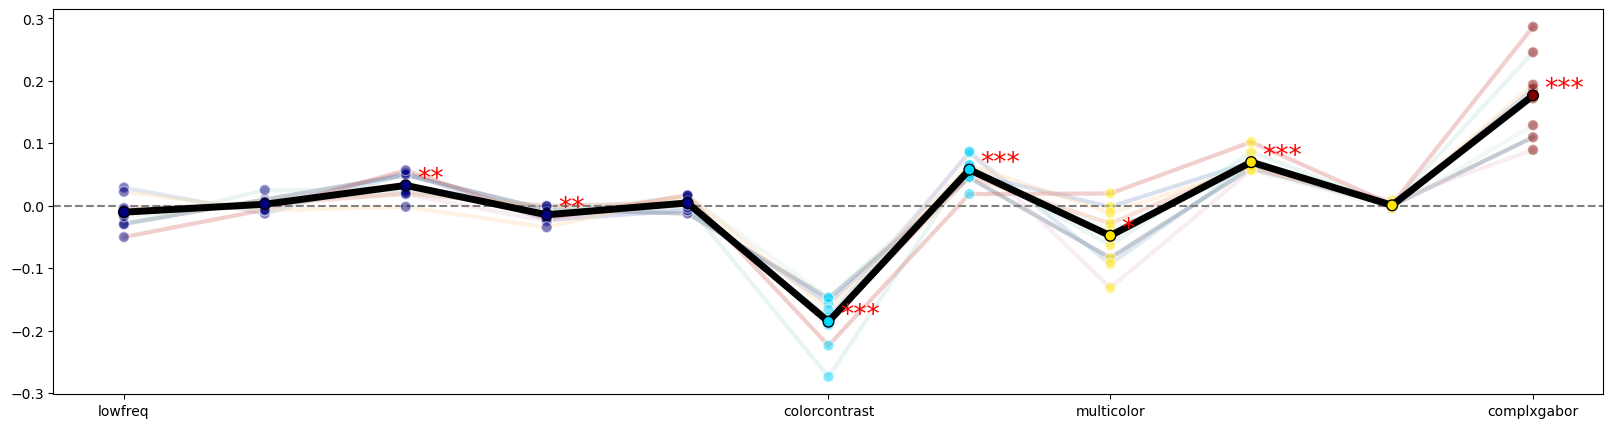

* : [7]
** : [3 4]
*** : [ 5  6  8 10]


In [20]:
# 信息量太大，简单summary成 sub x feature，按 set 聚类
# 确定筛选办法
methodname = 'fullm-significance' #'fullm-sigranktop50' #'double-significance' # 'mcoef-significance' #

subcolors = ['#404e67',  '#809bce',  '#95b8d1',  '#b8e0d4',  '#d6eadf',  '#eac4d5',  '#d1625c',  '#e89c81', '#ffd6a5']
label_dict = filtered_conv2_labels # conv2_labels
setcolors = plt.cm.jet(np.linspace(0, 1, len(label_dict.keys())))
draw_sorting = []
draw_colors = []
draw_ticks = []
draw_tickslabels = []
for key, indices in label_dict.items():
    iset = list(label_dict.keys()).index(key)
    set_color = setcolors[iset]
    draw_sorting.extend(list(indices))
    draw_colors.extend(len(indices)*[set_color])
    draw_ticks.append(len(indices))
    draw_tickslabels.append(key)
draw_ticks = [0] + list(np.cumsum(draw_ticks))
# 画个大图试试
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))
sub_feature_mean = np.zeros((len(subs), len(draw_sorting)))
# collect data
for isub, sub in enumerate(subs):
    sub_means = []
    for index in draw_sorting:
        # feature_sig_voxel = np.array(list(set(sig_roi[sub]) & set(np.where(pvalues[isub, index, :] < 0.05)[0])))
        feature_sig_voxel = method[methodname](sub, isub, index)
        sub_means.append(betas[isub, index, feature_sig_voxel].mean())
    sub_feature_mean[isub,:] = np.array(sub_means)
mean_sub_feature_mean = sub_feature_mean.mean(axis=0)
# plots
for isub, sub in enumerate(subs):
    ax.plot(sub_feature_mean[isub], color=subcolors[isub], lw=3, alpha=0.3)
    ax.scatter(np.arange(len(draw_sorting)), sub_feature_mean[isub], color=draw_colors, s=60, alpha=0.5, edgecolors='white', zorder=4)
ax.plot(mean_sub_feature_mean, color='black', lw=5,zorder=4)
ax.scatter(np.arange(len(draw_sorting)), sub_feature_mean.mean(axis=0), color=draw_colors, s=60, edgecolors='black', zorder=5)
ax.set_xlim([-0.5, len(draw_sorting)-.5])
ax.axhline(y=0, color='gray', ls='--')

from scipy import stats
_, p_value = stats.ttest_1samp(sub_feature_mean, 0)
for pos in np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]:
    infotxt = '*'
    ax.text(pos+0.08, sub_feature_mean.mean(axis=0)[pos]+0.01, infotxt, fontsize=19, color='red',
    horizontalalignment='left', verticalalignment='center', zorder=7)
for pos in np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]:
    infotxt = '**'
    ax.text(pos+0.08, sub_feature_mean.mean(axis=0)[pos]+0.01, infotxt, fontsize=19, color='red',
    horizontalalignment='left', verticalalignment='center',zorder=7)
for pos in np.where(p_value < 0.001)[0]:
    infotxt = '***'
    ax.text(pos+0.08, sub_feature_mean.mean(axis=0)[pos]+0.01, infotxt, fontsize=19, color='red',
    horizontalalignment='left', verticalalignment='center',zorder=7)
ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)

fig_path = pjoin(wk_dir, 'vis/group-feature-sig')
plt.savefig(pjoin(fig_path, f'Group_{methodname}-feature-space-component.jpg'), dpi=300, bbox_inches='tight')
plt.show()

print('* :', np.array(draw_sorting)[np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]] )
print('** :', np.array(draw_sorting)[np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]])
print('*** :', np.array(draw_sorting)[np.where(p_value < 0.001)[0]])

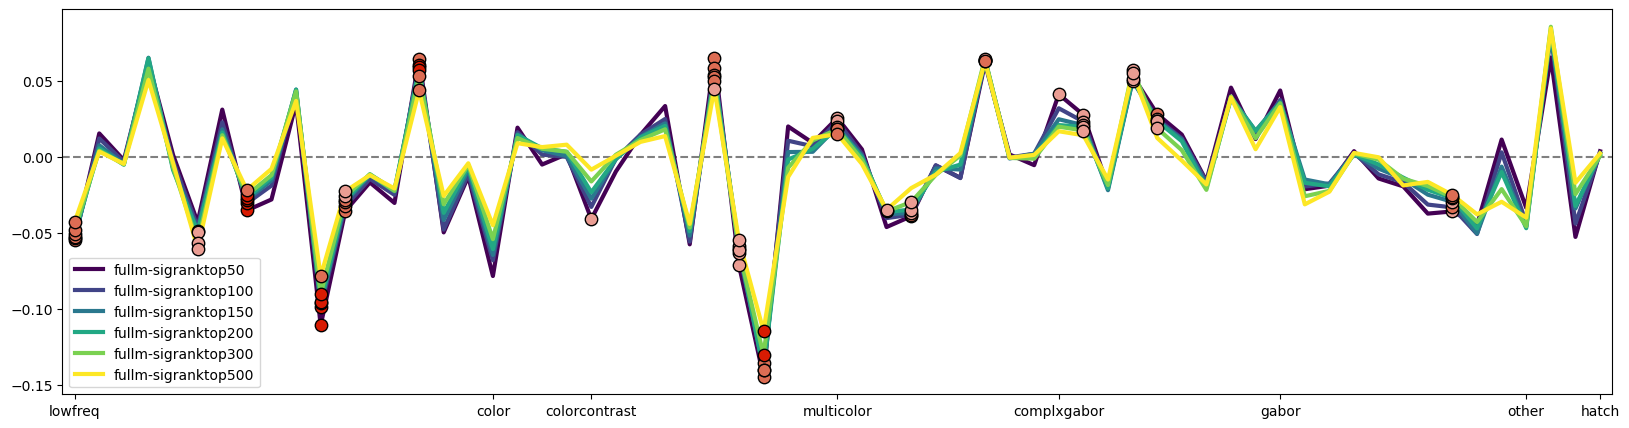

* : [60 29 21 42 35 25]
** : [ 1 49 28 37  3 57 18]
*** : [45]


In [34]:
# 画个大图试试
from scipy import stats
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))
sub_feature_mean = np.zeros((len(subs), len(draw_sorting)))
methodnames = list(method.keys())[3::]
linecolors = plt.cm.viridis(np.linspace(0, 1, len(methodnames)))
siglevelcolors = ["#ea9d93","#dd6d54","#d81b02"]
for iline, methodname in enumerate(methodnames):
    # collect data
    for isub, sub in enumerate(subs):
        sub_means = []
        for index in draw_sorting:
            # feature_sig_voxel = np.array(list(set(sig_roi[sub]) & set(np.where(pvalues[isub, index, :] < 0.05)[0])))
            feature_sig_voxel = method[methodname](sub, isub, index)
            sub_means.append(betas[isub, index, feature_sig_voxel].mean())
        sub_feature_mean[isub,:] = np.array(sub_means)
    mean_sub_feature_mean = sub_feature_mean.mean(axis=0)
    # significance test
    _, p_value = stats.ttest_1samp(sub_feature_mean, 0)
    
    # line plots
    ax.plot(mean_sub_feature_mean, color=linecolors[iline],label=methodname,  lw=3,zorder=4)
    # dot plots
    for pos in np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]:
        ax.scatter(np.arange(len(draw_sorting))[pos], mean_sub_feature_mean[pos], color=siglevelcolors[0], #color=draw_colors[pos], 
        s=80, edgecolors='black', lw=1, alpha=1, zorder=5)
    for pos in np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]:
        ax.scatter(np.arange(len(draw_sorting))[pos], mean_sub_feature_mean[pos], color=siglevelcolors[1], #color=draw_colors[pos], 
        s=80, edgecolors='black', lw=1, alpha=1, zorder=5)
    for pos in np.where(p_value < 0.001)[0]:
        ax.scatter(np.arange(len(draw_sorting))[pos], mean_sub_feature_mean[pos], color=siglevelcolors[2], #color=draw_colors[pos], 
        s=80, edgecolors='black', lw=1, alpha=1, zorder=5)
    # for pos in np.where((p_value >= 0.05)==1)[0]:
    #     ax.scatter(np.arange(len(draw_sorting))[pos], mean_sub_feature_mean[pos], color=draw_colors[pos], 
    #     s=40, edgecolors='white', lw=3, alpha=0.2, zorder=5)
    ax.set_xlim([-0.5, 62.5])
        

ax.axhline(y=0, color='gray', ls='--')
ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)
plt.legend()
# fig_path = pjoin(wk_dir, 'vis/group-feature-sig')
# plt.savefig(pjoin(fig_path, f'Group_{methodname}-feature-space-component.jpg'), dpi=300, bbox_inches='tight')
plt.show()

print('* :', np.array(draw_sorting)[np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]] )
print('** :', np.array(draw_sorting)[np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]])
print('*** :', np.array(draw_sorting)[np.where(p_value < 0.001)[0]])

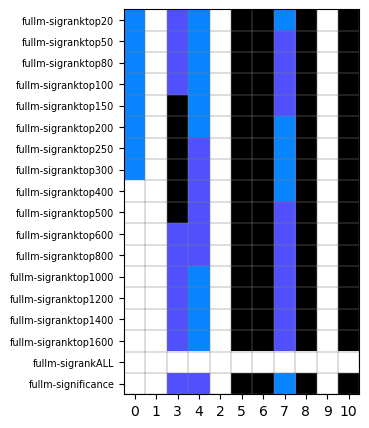

In [26]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches

sub_feature_mean = np.zeros((len(subs), len(draw_sorting)))
methodnames = list(method.keys())
siglevelcolors = ["white","#0a84ff", "#5050ff", "#000000"]
# 创建自定义颜色映射
cmap = LinearSegmentedColormap.from_list("custom_cmap", siglevelcolors)
pmatrix = np.zeros((len(methodnames), len(draw_sorting)))

for imethod, methodname in enumerate(methodnames):
    # collect data
    for isub, sub in enumerate(subs):
        sub_means = []
        for index in draw_sorting:
            # feature_sig_voxel = np.array(list(set(sig_roi[sub]) & set(np.where(pvalues[isub, index, :] < 0.05)[0])))
            feature_sig_voxel = method[methodname](sub, isub, index)
            try:
                sub_means.append(betas[isub, index, feature_sig_voxel].mean())
            except IndexError:
                print(isub, index, feature_sig_voxel,methodname)
                break
        sub_feature_mean[isub,:] = np.array(sub_means)
    mean_sub_feature_mean = sub_feature_mean.mean(axis=0)
    # significance test
    _, p_value = stats.ttest_1samp(sub_feature_mean, 0)
    pmatrix[imethod, np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]] = 1
    pmatrix[imethod, np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]] = 2
    pmatrix[imethod, np.where(p_value < 0.001)[0]] = 3

fig, ax = plt.subplots(1, 1, figsize=(21,5))
# matrix show
ax.imshow(pmatrix, cmap=cmap)
ax.set_xticks(np.arange(len(draw_sorting)))
ax.set_xticklabels(draw_sorting)
ax.set_yticks(np.arange(len(methodnames)))
ticklabels = methodnames # [_.replace('-', '\n') for _ in methodnames]
ax.set_yticklabels(ticklabels, fontsize=7)
# 获取单元格的数量
numrows, numcols = pmatrix.shape
# 为每个单元格添加边框
for x in range(numcols):
    for y in range(numrows):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, fill=False, edgecolor='gray', lw=0.2))

plt.show()
# [0,6,4,1,3,8,9,11,10,13,14]

In [24]:
sub_feature_mean.shape

(9, 11)

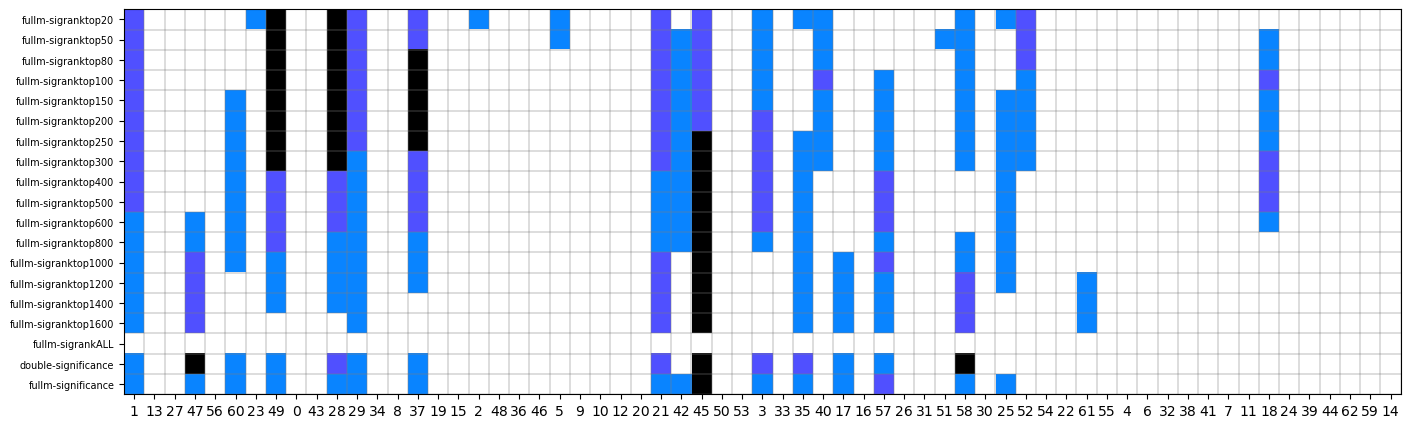

In [12]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches

sub_feature_mean = np.zeros((len(subs), len(draw_sorting)))
methodnames = list(method.keys())
siglevelcolors = ["white","#0a84ff", "#5050ff", "#000000"]
# 创建自定义颜色映射
cmap = LinearSegmentedColormap.from_list("custom_cmap", siglevelcolors)
pmatrix = np.zeros((len(methodnames), len(draw_sorting)))

for imethod, methodname in enumerate(methodnames):
    # collect data
    for isub, sub in enumerate(subs):
        sub_means = []
        for index in draw_sorting:
            # feature_sig_voxel = np.array(list(set(sig_roi[sub]) & set(np.where(pvalues[isub, index, :] < 0.05)[0])))
            feature_sig_voxel = method[methodname](sub, isub, index)
            sub_means.append(betas[isub, index, feature_sig_voxel].mean())
        sub_feature_mean[isub,:] = np.array(sub_means)
    mean_sub_feature_mean = sub_feature_mean.mean(axis=0)
    # significance test
    _, p_value = stats.ttest_1samp(sub_feature_mean, 0)
    pmatrix[imethod, np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]] = 1
    pmatrix[imethod, np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]] = 2
    pmatrix[imethod, np.where(p_value < 0.001)[0]] = 3

fig, ax = plt.subplots(1, 1, figsize=(21,5))
# matrix show
ax.imshow(pmatrix, cmap=cmap)
ax.set_xticks(np.arange(len(draw_sorting)))
ax.set_xticklabels(draw_sorting)
ax.set_yticks(np.arange(len(methodnames)))
ticklabels = methodnames # [_.replace('-', '\n') for _ in methodnames]
ax.set_yticklabels(ticklabels, fontsize=7)
# 获取单元格的数量
numrows, numcols = pmatrix.shape
# 为每个单元格添加边框
for x in range(numcols):
    for y in range(numrows):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, fill=False, edgecolor='gray', lw=0.2))

plt.show()

In [95]:
np.array(draw_sorting)[np.where(((pmatrix>0).sum(axis=0))>0)[0]], \
np.array(draw_sorting)[np.where(((pmatrix>0).sum(axis=0))>0)[0]].shape

(array([ 1, 47, 60, 23, 49, 28, 29, 37,  2,  5, 21, 42, 45,  3, 35, 40, 17,
        57, 51, 58, 25, 52, 61, 18]),
 (24,))

In [2]:
import scipy
import numpy
print(numpy.__version__)
print(scipy.__version__)

1.19.5
1.10.1


### 各特征contrast效应在ROI上的显著性

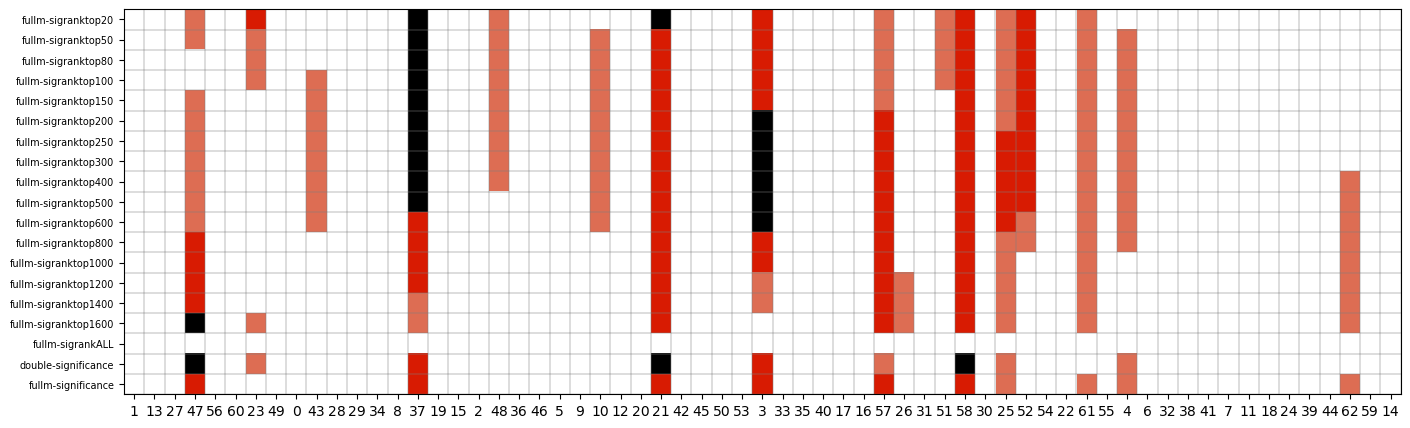

In [15]:
# 计算 roi 内的 contrast 
z_contrast = np.nan*np.zeros_like(betas)

# make contrast matrix
ndim = betas.shape[1]
contrast = -1 * np.ones((ndim, ndim))
np.fill_diagonal(contrast, ndim-1)

# case1 对整个 prim 做 z map
show_roi = voxel_indices # v1_voxels # 
contrast_betas = np.dot(contrast, betas[:,:,show_roi]).transpose((1,0,2)) # transpsoe shape into (n_subj, n_feature, n_voxel)
z_contrast[:, :, show_roi] = contrast_betas
# z_contrast[:, :, show_roi] = ((contrast_betas.transpose((2,0,1)) - np.nanmean(contrast_betas, axis=2)) / np.nanstd(contrast_betas, axis=2)).transpose((1,2,0))
    
# 筛选原则函数
method = {
          'fullm-sigranktop20': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:20],
          'fullm-sigranktop50': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:50],
          'fullm-sigranktop80': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:80],
          'fullm-sigranktop100': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:100],
          'fullm-sigranktop150': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:150],
          'fullm-sigranktop200': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:200],
          'fullm-sigranktop250': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:250],
          'fullm-sigranktop300': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:300],
          'fullm-sigranktop400': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:400],
          'fullm-sigranktop500': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:500],
          'fullm-sigranktop600': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:600],
          'fullm-sigranktop800': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:800],
          'fullm-sigranktop1000': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:1000],
          'fullm-sigranktop1200': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:1200],
          'fullm-sigranktop1400': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:1400],
          'fullm-sigranktop1600': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub][0:1600],
          'fullm-sigrankALL': lambda x_sub, y_isub, z_index : sigrank_roi[x_sub],
          'double-significance': lambda x_sub, y_isub, z_index :np.array(list(set(sig_roi[x_sub]) & set(np.where(pvalues[y_isub, z_index, :] < 0.05)[0]))),
          'fullm-significance':  lambda x_sub, y_isub, z_index :sig_roi[x_sub],   
          }

# 创建自定义颜色映射
siglevelcolors = ["white","#dd6d54","#d81b02", "#000000"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", siglevelcolors)
pmatrix = np.zeros((len(methodnames), len(draw_sorting)))
methodnames = list(method.keys())
for imethod, methodname in enumerate(methodnames):
    # collect data
    for isub, sub in enumerate(subs):
        sub_means = []
        for index in draw_sorting:
            # feature_sig_voxel = np.array(list(set(sig_roi[sub]) & set(np.where(pvalues[isub, index, :] < 0.05)[0])))
            feature_sig_voxel = method[methodname](sub, isub, index)
            sub_means.append(z_contrast[isub, index, feature_sig_voxel].mean())
        sub_feature_mean[isub,:] = np.array(sub_means)
    mean_sub_feature_mean = sub_feature_mean.mean(axis=0)
    # significance test
    _, p_value = stats.ttest_1samp(sub_feature_mean, 0)
    _, p_value = stats.ttest_1samp(sub_feature_mean, 0, alternative='greater')
    pmatrix[imethod, np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]] = 1
    pmatrix[imethod, np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]] = 2
    pmatrix[imethod, np.where(p_value < 0.001)[0]] = 3

fig, ax = plt.subplots(1, 1, figsize=(21,5))
# matrix show
ax.imshow(pmatrix, cmap=cmap)
ax.set_xticks(np.arange(len(draw_sorting)))
ax.set_xticklabels(draw_sorting)
ax.set_yticks(np.arange(len(methodnames)))
ticklabels = methodnames # [_.replace('-', '\n') for _ in methodnames]
ax.set_yticklabels(ticklabels, fontsize=7)
# 获取单元格的数量
numrows, numcols = pmatrix.shape
# 为每个单元格添加边框
for x in range(numcols):
    for y in range(numrows):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, fill=False, edgecolor='gray', lw=0.2))

plt.show()

In [16]:
np.array(draw_sorting)[np.where(((pmatrix>0).sum(axis=0))>0)[0]], \
np.array(draw_sorting)[np.where(((pmatrix>0).sum(axis=0))>0)[0]].shape

(array([47, 23, 43, 37, 48, 10, 21,  3, 57, 26, 51, 58, 25, 52, 61,  4, 62]),
 (17,))

In [87]:
np.where(((pmatrix>0).sum(axis=0))>0)[0]

array([ 0,  3,  5,  6,  7,  9, 10, 11, 14, 17, 21, 23, 26, 27, 28, 31, 33,
       34, 35, 37, 38, 40, 41, 43, 44, 47, 49, 56])

In [90]:
((pmatrix>0).sum(axis=1))

array([14, 15, 17, 16, 18, 16, 19, 19, 17, 16, 17, 14, 14, 13, 11, 12,  0,
       14, 14])